code by Park Seoyeon @seoyeon960406
- 2019-12
- tensorflow v1

## 형태소 분석 완료된 파일로 실행
- 형태소 분석은 울산대학교의 UTagger를 사용했음

In [1]:
def open_tokenized_file(filename):
    tokens, labels = [], []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            line = line.replace('\n', '').split('\t')
            tokens.append(line[0].split())
            labels.append(line[1])
    return tokens, labels 

In [2]:
train_tokens, train_labels = open_tokenized_file('./data_in/tokenized_rating_train.txt')
test_tokens, test_labels = open_tokenized_file('./data_in/tokenized_rating_test.txt')

In [3]:
print(train_tokens[0], train_labels[0])

['아__02/IC', '더빙/NNG', './SF', './SF', '진짜/NNG', '짜증/NNG', '나__01/VV', '네/EC', '요/JX', '목소리/NNG'] 0


## 음절, 자소 임베딩을 위해 띄어쓰기 교정한 데이터 open

In [4]:
def open_file(filename):
    reviews = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            line = line.replace('\n', '').split('\t')
            reviews.append(line[0])
    return reviews 

In [5]:
train_reviews = open_file('./data_in/preprocessed_rating_train.txt')
test_reviews = open_file('./data_in/preprocessed_rating_test.txt')

In [6]:
train_reviews[0]

'아 더빙.. 진짜 짜증나네요 목소리'

## 음절 분리

In [7]:
# 문장을 음절 단위로 구분
def sent2eom(sentence):
    eomjeols = []
    for eomjeol in sentence:
        if eomjeol!=' ':
            eomjeols.append(eomjeol)
    return eomjeols

In [8]:
train_chars = [sent2eom(sent) for sent in train_reviews]
test_chars = [sent2eom(sent) for sent in test_reviews]

In [9]:
char_lens = [len(sent) for sent in train_chars]
max_char_length = max(char_lens)

In [10]:
max_char_length

140

## 자소 분리
- https://github.com/moonbings/naver-ai-hackathon-2018/blob/master/movie
- dataset.py와 kor_char_parser.py를 활용

In [11]:
from kor_char_parser import *
from dataset import preprocess

In [12]:
train_jaso = preprocess(train_reviews, max_char_length)
test_jaso = preprocess(test_reviews, max_char_length)

In [13]:
print(train_tokens[0])
print(train_chars[0])
print(train_jaso[0])

['아__02/IC', '더빙/NNG', './SF', './SF', '진짜/NNG', '짜증/NNG', '나__01/VV', '네/EC', '요/JX', '목소리/NNG']
['아', '더', '빙', '.', '.', '진', '짜', '짜', '증', '나', '네', '요', '목', '소', '리']
[ 11  19  99   3  23   7  39  60 113 113  99  12  39  43  13  19  99  13
  19  12  37  60   2  19   2  24  11  31  99   6  27  40   9  27   5  39
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## 감성분석 모델 학습
- tensorflow v1 사용 중
- 병렬형 stacked BiLSTM 사용

In [14]:
import tensorflow as tf
import numpy as np

In [15]:
#word2vec.py
import word2vec

In [16]:
w2v = word2vec.Word2Vec()

In [17]:
index = int(len(train_tokens)*0.9)

train_tokens, val_tokens = train_tokens[:index], train_tokens[index:]
train_chars, val_chars = train_chars[:index], train_chars[index:]
train_jaso, val_jaso = train_jaso[:index], train_jaso[index:]
train_labels, val_labels = train_labels[:index], train_labels[index:]

In [18]:
train_Token = w2v.corpus2vec('./model/movie_word2vec300.model',train_tokens)
train_Char = w2v.corpus2vec('./model/movie_char2vec300.model', train_chars)
train_Jaso = train_jaso
train_Y = w2v.onehot(train_labels)

In [19]:
val_Token = w2v.corpus2vec('./model/movie_word2vec300.model',val_tokens)
val_Char = w2v.corpus2vec('./model/movie_char2vec300.model', val_chars)
val_Jaso = val_jaso
val_Y = w2v.onehot(val_labels)

In [20]:
batch_size = 256
vector_size = 300
character_size = 251 #음절을 자소 분리를 했을 때, 총 251개의 값이 존재
seq_list = [len(x) for x in train_tokens]
max_seq_length = max(seq_list) #140
learning_rate = 0.001
lstm_units = 128
num_class = 2 # 분류할 클래스 수(긍정, 부정)
training_epochs = 100
n_layers = 2

In [21]:
def reset_graph(seed=0):
    tf.reset_default_graph()
    tf.set_random_seed(seed)

In [22]:
reset_graph()

In [23]:
XT = tf.placeholder(tf.float32, shape=[None, max_seq_length, vector_size])
XC = tf.placeholder(tf.float32, shape=[None, max_char_length, vector_size])
XJ = tf.placeholder(tf.int32, shape=[None, max_char_length])
Y = tf.placeholder(tf.float32, shape=[None, num_class])
keep_prob = tf.placeholder(tf.float32)

In [24]:
jaso_embedding = tf.get_variable('jaso_embedding', [character_size, vector_size])
jaso_embedded = tf.nn.embedding_lookup(jaso_embedding, XJ)

In [25]:
W = tf.get_variable(name='W', shape=[6*lstm_units, num_class], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable(name='b', shape=[num_class], dtype=tf.float32, initializer=tf.zeros_initializer())

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [26]:
def basic_cell():
    rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(lstm_units)
    rnn_cell = tf.nn.rnn_cell.DropoutWrapper(rnn_cell, output_keep_prob=keep_prob)
    return rnn_cell

In [27]:
input_ = XT
for n in range(n_layers):
    with tf.variable_scope('word-lstm_layer{}'.format(n), reuse=tf.AUTO_REUSE):
        cell_fw, cell_bw = basic_cell(), basic_cell()
        word_outputs, word_states = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, input_, dtype=tf.float32)
        word_output = tf.concat(word_outputs,2)
        input_ = word_output

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [28]:
input_ = XC
for n in range(n_layers):
    with tf.variable_scope('char-lstm_layer{}'.format(n), reuse=tf.AUTO_REUSE):
        cell_fw, cell_bw = basic_cell(), basic_cell()
        char_outputs, char_states = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, input_, dtype=tf.float32)
        char_output = tf.concat(char_outputs,2)
        input_ = char_output

In [29]:
input_ = jaso_embedded
for n in range(n_layers):
    with tf.variable_scope('jaso-lstm_layer{}'.format(n), reuse=tf.AUTO_REUSE):
        cell_fw, cell_bw = basic_cell(), basic_cell()
        jaso_outputs, jaso_states = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, input_, dtype=tf.float32)
        jaso_output = tf.concat(jaso_outputs,2)
        input_ = jaso_output

In [30]:
word_final_states = tf.concat([word_states[1][0], word_states[1][1]], 1)
char_final_states = tf.concat([char_states[1][0], char_states[1][1]], 1)
jaso_final_states = tf.concat([jaso_states[1][0], jaso_states[1][1]], 1)

In [31]:
final_states = tf.concat([word_final_states, char_final_states, jaso_final_states], axis=1)

In [32]:
logits = tf.matmul(final_states, W) + b

In [33]:
with tf.variable_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [34]:
prediction = tf.nn.softmax(logits)

In [35]:
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [36]:
init = tf.global_variables_initializer()

In [37]:
modelName = "./sentiment-parallel_LSTM_model.ckpt"
saver = tf.train.Saver()

In [38]:
train_acc, train_loss = [], []
val_acc, val_loss = [], []

best_accuracy = 0
max_checks = 5
checks_without_progress = 0

In [39]:
def shuffle_batch(XT, XC, XJ, y, batch_size):
    rnd_idx = np.random.permutation(len(XT))
    n_batches = len(XT) // (batch_size)
    XT_, XC_, XJ_, y_ = XT[rnd_idx], XC[rnd_idx], XJ[rnd_idx], y[rnd_idx]
    for step in range(n_batches):
        start = step*batch_size
        XT_batch, XC_batch = XT_[start:start+batch_size], XC_[start:start+batch_size]
        XJ_batch, y_batch = XJ_[start:start+batch_size], y_[start:start+batch_size]
        yield XT_batch, XC_batch, XJ_batch, y_batch

In [40]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        avg_acc, avg_loss = [] , []
        print('=====TRAIN======')
        for XT_batch, XC_batch, XJ_batch, y_batch in shuffle_batch(train_Token, train_Char, train_Jaso, train_Y, batch_size):
            if len(XT_batch)!=batch_size:
                break
                
            w2v.load_model('./model/movie_word2vec300.model')
            XT_batch =w2v.zero_padding(XT_batch, batch_size, max_seq_length, vector_size)
            w2v.load_model('./model/movie_char2vec300.model')
            XC_batch =w2v.zero_padding(XC_batch, batch_size, max_char_length, vector_size)
            
            los, _, acc = sess.run([loss, optimizer, accuracy],
                        feed_dict={XT:XT_batch, XC:XC_batch, XJ:XJ_batch, Y:y_batch, keep_prob:0.75})
            
            avg_acc.append(acc)
            avg_loss.append(los)
        train_acc.append(sum(avg_acc)/len(avg_acc))
        train_loss.append(sum(avg_loss)/len(avg_loss))
        print('Eopch:{:2d}, cost={:9f}'.format((epoch+1), sum(avg_loss)/len(avg_loss)))
        print('Train Accuracy:', sum(avg_acc)/len(avg_acc))
        
        avg_acc, avg_loss = [] , []
        print('=====VALID======')
        for val_XT_batch, val_XC_batch, val_XJ_batch, val_y_batch in shuffle_batch(val_Token, val_Char, val_Jaso, val_Y, batch_size):
            if len(val_XT_batch)!=batch_size:
                break
                
            w2v.load_model('./model/movie_word2vec300.model')
            val_XT_batch =w2v.zero_padding(val_XT_batch, batch_size, max_seq_length, vector_size)
            w2v.load_model('./model/movie_char2vec300.model')
            val_XC_batch =w2v.zero_padding(val_XC_batch, batch_size, max_char_length, vector_size)
            
            v_los = loss.eval(feed_dict={XT:val_XT_batch, XC:val_XC_batch,
                                         XJ:val_XJ_batch, Y:val_y_batch, keep_prob:1.0})
            v_acc = accuracy.eval(feed_dict={XT:val_XT_batch, XC:val_XC_batch,
                                         XJ:val_XJ_batch, Y:val_y_batch, keep_prob:1.0})
            
            avg_acc.append(v_acc)
            avg_loss.append(v_los)
        val_acc.append(sum(avg_acc)/len(avg_acc))
        val_loss.append(sum(avg_loss)/len(avg_loss))
        print('Eopch:{:2d}, cost={:9f}'.format((epoch+1), sum(avg_loss)/len(avg_loss)))
        print('Validation Accuracy:', sum(avg_acc)/len(avg_acc))
        
        v_avg_acc = sum(avg_acc)/len(avg_acc)
        # 조기종료를 위한 부분
        # 5번 이상 정확률이 떨어진 경우, 종료
        if v_avg_acc>best_accuracy:
            save_path = saver.save(sess, modelName)
            best_accuracy = v_avg_acc
            checks_without_progress = 0
        else:
            checks_without_progress+=1
            if checks_without_progress >= max_checks:
                print('조기종료')
                break
                
        print()

=====TRAIN======
Eopch: 1, cost= 0.378914
Train Accuracy: 0.8296370967741935
=====VALID======
Eopch: 1, cost= 0.343659
Validation Accuracy: 0.8498787715517241

=====TRAIN======
Eopch: 2, cost= 0.318253
Train Accuracy: 0.861146525142315
=====VALID======
Eopch: 2, cost= 0.298582
Validation Accuracy: 0.8697467672413793

=====TRAIN======
Eopch: 3, cost= 0.289994
Train Accuracy: 0.874881404174573
=====VALID======
Eopch: 3, cost= 0.290639
Validation Accuracy: 0.8760775862068966

=====TRAIN======
Eopch: 4, cost= 0.270247
Train Accuracy: 0.884584025142315
=====VALID======
Eopch: 4, cost= 0.286726
Validation Accuracy: 0.8793776939655172

=====TRAIN======
Eopch: 5, cost= 0.251608
Train Accuracy: 0.8948796252371917
=====VALID======
Eopch: 5, cost= 0.280332
Validation Accuracy: 0.880926724137931

=====TRAIN======
Eopch: 6, cost= 0.233858
Train Accuracy: 0.9030108515180265
=====VALID======
Eopch: 6, cost= 0.279319
Validation Accuracy: 0.882745150862069

=====TRAIN======
Eopch: 7, cost= 0.216277
Tra

In [41]:
#조기종료 시접
early_stop = val_acc.index(max(val_acc))
print(early_stop)

7


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

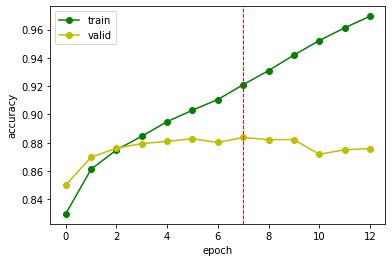

In [43]:
# 조기종료 시점
plt.plot(train_acc, color='g', marker='o')
plt.plot(val_acc, color='y', marker='o')
plt.axvline(x=early_stop, color='r', linestyle='--', linewidth=1)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'])

## 학습한 모델 성능 평가

In [45]:
test_Token = w2v.corpus2vec('./model/movie_word2vec300.model',test_tokens)
test_Char = w2v.corpus2vec('./model/movie_char2vec300.model', test_chars)
test_Jaso = test_jaso
test_Y = w2v.onehot(test_labels)

In [49]:
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, modelName)
    
    print('=====TEST=====')
    avg_acc, avg_loss = [] , []
    for XT_batch, XC_batch, XJ_batch, y_batch in shuffle_batch(test_Token, test_Char, test_Jaso, test_Y, batch_size):
        if len(XT_batch)!=batch_size:
            break
                
        w2v.load_model('./model/movie_word2vec300.model')
        XT_batch =w2v.zero_padding(XT_batch, batch_size, max_seq_length, vector_size)
        w2v.load_model('./model/movie_char2vec300.model')
        XC_batch =w2v.zero_padding(XC_batch, batch_size, max_char_length, vector_size)
            
        los, _, acc = sess.run([loss, optimizer, accuracy],
                    feed_dict={XT:XT_batch, XC:XC_batch, XJ:XJ_batch, Y:y_batch, keep_prob:1.0})
            
        avg_acc.append(acc)
        avg_loss.append(los)
     
    print('cost={:9f}'.format(sum(avg_loss)/len(avg_loss)))
    print('Test Accuracy:', sum(avg_acc)/len(avg_acc))

INFO:tensorflow:Restoring parameters from ./sentiment-parallel_LSTM_model.ckpt
=====TEST=====
cost= 0.296752
Test Accuracy: 0.8721955128205128
